In [1]:
import os
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_json("Indian_Number_plates.json", lines=True)
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [3]:
df['image_name'] = 'license_plate_' + (df.index + 1).astype(str).str.zfill(3) + '.jpeg'

df2 = df.annotation.apply(lambda x: pd.Series({
    'top_x': x[0]['points'][0]['x'],
    'top_y': x[0]['points'][0]['y'],
    'bottom_x': x[0]['points'][1]['x'],
    'bottom_y': x[0]['points'][1]['y'],
    'width': x[0]['imageWidth'],
    'height': x[0]['imageHeight']
}))

df = pd.concat([df[['image_name', 'content']], df2], axis=1)
df.head()

,image_name,content,top_x,top_y,bottom_x,bottom_y,width,height
0,license_plate_001.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.722084,0.587983,0.868486,0.688841,806.0,466.0
1,license_plate_002.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.161943,0.850780,0.582996,1.000000,494.0,449.0
2,license_plate_003.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.082000,0.697452,0.230000,0.828025,500.0,314.0
3,license_plate_004.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.434000,0.667377,0.718000,0.765458,500.0,469.0
4,license_plate_005.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.208791,0.390764,0.865135,0.984014,1001.0,563.0


In [4]:
print('LOADING IMAGES...')
for _, row in df.iterrows():
#     os.system(f"curl -o images/{row['image_name']} {row['content']}")
    pass

LOADING IMAGES...


In [5]:
test_samples = np.random.randint(0, len(df), 5)

df_test= df.iloc[test_samples].reset_index(drop=True)
df_train = df.drop(test_samples, axis=0).reset_index(drop=True)

In [6]:
def show_plate(idx):
    image = cv2.imread(f'images/{df_train.image_name[idx]}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224, 224)) # VGG Input

    tx = int(df_train.top_x[idx] * 224)
    ty = int(df_train.top_y[idx] * 224)
    bx = int(df_train.bottom_x[idx] * 224)
    by = int(df_train.bottom_y[idx] * 224)
    
    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 255, 0), 1)
    
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.title(df_train.image_name[idx])
    plt.imshow(image)

    plt.show()

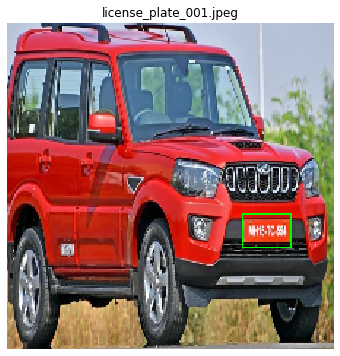

In [7]:
show_plate(0)

In [8]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    df_train,
    directory='images/',
    x_col='image_name',
    y_col=['top_x', 'top_y', 'bottom_x', 'bottom_y'],
    target_size=(224, 224),
    batch_size=32, 
    class_mode='other',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    df_train,
    directory='images/',
    x_col='image_name',
    y_col=['top_x', 'top_y', 'bottom_x', 'bottom_y'],
    target_size=(224, 224),
    batch_size=32, 
    class_mode='other',
    subset='validation'
)

Found 209 validated image filenames.
Found 23 validated image filenames.


In [9]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
Non-trainable params: 14,714,688
____________________________________

In [10]:
STEP_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step:", STEP_TRAIN)
print("Validation step:", STEP_VAL)

train_generator.reset()
validation_generator.reset()

Train step: 7
Validation step: 1


In [11]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss='MSE')

In [14]:
# model.fit_generator(
history = model.fit(
    train_generator, 
    validation_data=validation_generator,
    steps_per_epoch=STEP_TRAIN,
    validation_steps=STEP_VAL,
    epochs=30)

Epoch 1/30
7/7 [==============================] - 31s 4s/step - loss: 5.6119e-04 - val_loss: 0.0133
Epoch 2/30
7/7 [==============================] - 36s 5s/step - loss: 4.8749e-04 - val_loss: 0.0127
Epoch 3/30
7/7 [==============================] - 34s 5s/step - loss: 6.1061e-04 - val_loss: 0.0125
Epoch 4/30
7/7 [==============================] - 32s 5s/step - loss: 6.2580e-04 - val_loss: 0.0127
Epoch 5/30
7/7 [==============================] - 36s 5s/step - loss: 4.2258e-04 - val_loss: 0.0129
Epoch 6/30
7/7 [==============================] - 37s 5s/step - loss: 5.4761e-04 - val_loss: 0.0123
Epoch 7/30
7/7 [==============================] - 37s 5s/step - loss: 4.9339e-04 - val_loss: 0.0120
Epoch 8/30
7/7 [==============================] - 37s 5s/step - loss: 7.4251e-04 - val_loss: 0.0124
Epoch 9/30
7/7 [==============================] - 37s 5s/step - loss: 8.2995e-04 - val_loss: 0.0124
Epoch 10/30
7/7 [==============================] - 39s 6s/step - loss: 7.3915e-04 - val_loss: 0.0127

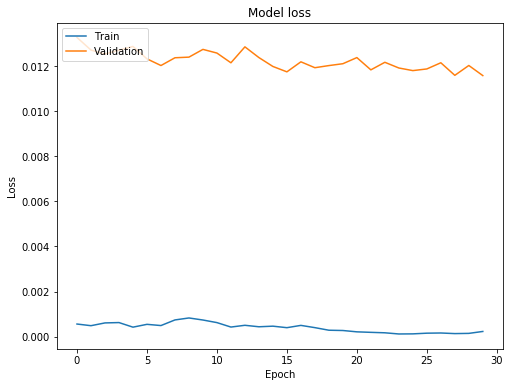

In [17]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
model.evaluate(validation_generator, steps=STEP_VAL)

1/1 [==============================] - 0s 1ms/step - loss: 0.0116


0.01157472562044859

In [26]:
y_hat

array([  1.6222942,  45.554317 , 222.58598  , 142.59161  ], dtype=float32)

In [32]:
df_test.image_name

,image_name,content,top_x,top_y,bottom_x,bottom_y,width,height
0,license_plate_170.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.048000,0.264000,0.996000,0.796000,250.0,250.0
1,license_plate_067.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.184891,0.300683,0.719682,0.646925,503.0,439.0
2,license_plate_199.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.325000,0.590504,0.466667,0.694362,600.0,337.0
3,license_plate_064.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.105105,0.390000,0.576577,0.544000,333.0,500.0
4,license_plate_192.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.346875,0.729687,0.672917,0.829687,960.0,1280.0


In [40]:
image

array([[[0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        ...,
        [0.00586234, 0.04507803, 0.01370548],
        [0.03015206, 0.06936774, 0.0379952 ],
        [0.0092437 , 0.04845938, 0.01708684]],

       [[0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        ...,
        [0.00106042, 0.04027611, 0.00890356],
        [0.        , 0.03531412, 0.00394158],
        [0.01316527, 0.05238095, 0.0210084 ]],

       [[0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        ...,
        [0.01634654, 0.05556222, 0.02418968],
        [0.00398159, 0.04319728, 0.01182473],
        [0.00868347, 0.04789916, 0.01652661]],

       ...,

       [[0.43519408, 0.4570028 , 0.43237296],
        [0.37032813, 0.39037615, 0.36662665],
        [0.42434973, 0

In [59]:
model.predict(img.reshape(1, 224, 224, 3) / 255) * 224

array([[ 66.44464, 139.37238, 151.18814, 174.6313 ]], dtype=float32)

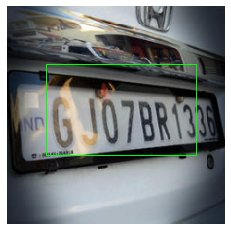

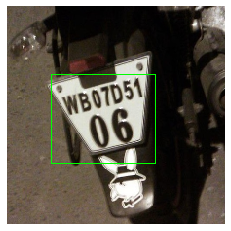

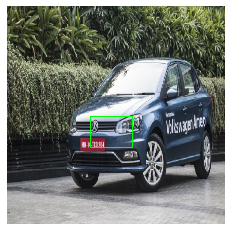

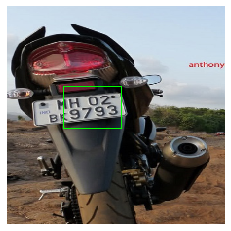

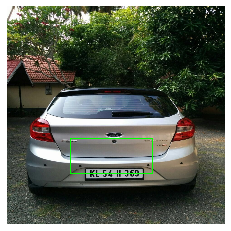

In [61]:
for name in df_test.image_name:    
    img = cv2.resize(cv2.imread("images/" + name), dsize=(224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    y_hat = model.predict(img.reshape(1, 224, 224, 3) / 255)[0] * 224
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 255, 0), 1)

    plt.imshow(image)
    plt.axis('off')
    plt.show()